In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wbdata

# Child marriage

Chil marriage over the past years (2007-2017), has child marriage dropped? (marriage before 15 and marriage before 18 (data checking/ fact checking) and if this rate contineous, will goal 5.3 be reached in 2030?(extrapoleren):
    - Child marriage percentage per country over time 
        -How was it in the past
        -how is it now
        -how will it develop over time    
    - marriage before 15
    - marriage before 18
    - woman who have to obey their husband by law

Child marriage per country over time

Data about child marriage from the past. This data shows the perecentage of women who were first married by age 18.

In [2]:
# married18_all = pd.DataFrame(wbdata.get_data("SP.M18.2024.FE.ZS"))
# married18_all['country'] = married18_all.country.astype(str).str.slice(23,-2)
# married18_all['indicator'] = married18_all.indicator.astype(str).str.slice(35,-2)
# married18_all['value'] = married18_all.value.astype(float).round(1)
# married18 = married18.loc[married18["value"] >= 0]
# married18

#### Deze data laat zien hoe het er nu voor staat met het aantal child marriages

This data shows the percentage of women who were first married by the age of 15.

In [11]:
married15_all = pd.DataFrame(wbdata.get_data("SP.M15.2024.FE.ZS"))
married15_all['country'] = married15_all.country.astype(str).str.slice(23,-2)
married15_all['indicator'] = married15_all.indicator.astype(str).str.slice(35,-2)
married15_all['value'] = married15_all.value.astype(float).round(1)


#find rows where the value is greater than 0
married15_all = married15_all.loc[(married15_all["value"] >= 0)]

#find the rows with the most recent data
married15_now = married15_all.sort_values("date", ascending = False).drop_duplicates(["country"])
married15_now["date"] = married15_now.date.astype(str)
married15_now

,country,date,decimal,indicator,value
7889,India,2016,2,: 'Women who were first married by age 15 (% o...,5.4
3017,Angola,2016,2,: 'Women who were first married by age 15 (% o...,7.9
3191,Armenia,2016,2,: 'Women who were first married by age 15 (% o...,0.0
10789,Nepal,2016,2,: 'Women who were first married by age 15 (% o...,7.0
9687,Malawi,2016,2,: 'Women who were first married by age 15 (% o...,9.0
13805,Tanzania,2016,2,: 'Women who were first married by age 15 (% o...,5.2
6439,Ethiopia,2016,2,: 'Women who were first married by age 15 (% o...,14.1
10615,Myanmar,2016,2,: 'Women who were first married by age 15 (% o...,1.9
12413,Senegal,2016,2,: 'Women who were first married by age 15 (% o...,7.9
2728,Afghanistan,2015,2,: 'Women who were first married by age 15 (% o...,8.8


Because we only look at the top 15 countries with the lowest equality rate. A new dataframe is made only containing the countries with this low equality rate compared.

In [4]:
CPIA_worst15 = pd.read_csv("CPIA_worst15.csv")
CPIA_worst15["date"] = CPIA_worst15["date"].astype(str)    

In [12]:
# Omdat er geen data is van 2017, heb ik de meeest recente data gebruikt. Zelfs hiervan is missing data.

married15_worst15 = pd.merge( CPIA_worst15, married15_now, how = "left", left_on = ["country"], right_on = ["country"])
married15_worst15

,Unnamed: 0,country,date_x,decimal_x,indicator_x,value_x,country_code,date_y,decimal_y,indicator_y,value_y
0,15138,"Yemen, Rep.",2017,1,CPIA gender equality rating (1=low to 6=high),1.5,YE,2013,2,: 'Women who were first married by age 15 (% o...,9.4
1,12934,Somalia,2017,1,CPIA gender equality rating (1=low to 6=high),2.0,SO,NaN,NaN,NaN,NaN
2,7482,Guinea-Bissau,2017,1,CPIA gender equality rating (1=low to 6=high),2.0,GW,NaN,NaN,NaN,NaN
3,13050,South Sudan,2017,1,CPIA gender equality rating (1=low to 6=high),2.0,SS,NaN,NaN,NaN,NaN
4,9860,Mali,2017,1,CPIA gender equality rating (1=low to 6=high),2.5,ML,2013,2,: 'Women who were first married by age 15 (% o...,22.8
5,6264,Eritrea,2017,1,CPIA gender equality rating (1=low to 6=high),2.5,ER,2002,2,: 'Women who were first married by age 15 (% o...,19.6
6,11078,Niger,2017,1,CPIA gender equality rating (1=low to 6=high),2.5,NE,2012,2,: 'Women who were first married by age 15 (% o...,28.0
7,8642,Kiribati,2017,1,CPIA gender equality rating (1=low to 6=high),2.5,KI,NaN,NaN,NaN,NaN
8,5278,"Congo, Dem. Rep.",2017,1,CPIA gender equality rating (1=low to 6=high),2.5,CD,2014,2,: 'Women who were first married by age 15 (% o...,10.0
9,4930,Chad,2017,1,CPIA gender equality rating (1=low to 6=high),2.5,TD,2015,2,: 'Women who were first married by age 15 (% o...,29.7


Text(0,0.5,'Percentage')

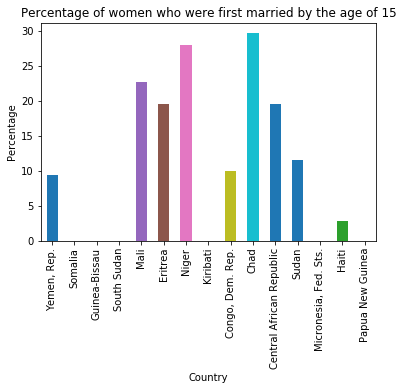

In [6]:
# bar plot van alle landen. 

# jaartal van data van married 15 moet nog in de bar plot, aangezien geen data beschikbaar is van 2017. 
# Hiervan moeten we misschien ook nog andere dataset gebruiken, zodat deze aangevuld kan worden. 

married15_worst15.plot(kind="bar", x = "country", y = "value_y", legend = False)

plt.title("Percentage of women who were first married by the age of 15")
plt.xlabel("Country")
plt.ylabel("Percentage")

In [7]:
# missing values aanvullen met een andere database?
# visualiseren dat de data van married 15 van sommige landen niet recent is. 


#### Data van vroeger tot nu

In [13]:
# married15_all gebruiken om te kunnen laten zien hoe het aantal kindhuwelijken over de jaren heen is veranderd

married15_past = married15_all.loc[((married15_all["country"].isin(CPIA_worst15["country"]))),:]

married15_past

,country,date,decimal,indicator,value
4894,Central African Republic,1995,2,: 'Women who were first married by age 15 (% o...,19.6
4932,Chad,2015,2,: 'Women who were first married by age 15 (% o...,29.7
4943,Chad,2004,2,: 'Women who were first married by age 15 (% o...,34.5
4950,Chad,1997,2,: 'Women who were first married by age 15 (% o...,28.6
5281,"Congo, Dem. Rep.",2014,2,: 'Women who were first married by age 15 (% o...,10.0
5288,"Congo, Dem. Rep.",2007,2,: 'Women who were first married by age 15 (% o...,8.3
6279,Eritrea,2002,2,: 'Women who were first married by age 15 (% o...,19.6
6286,Eritrea,1995,2,: 'Women who were first married by age 15 (% o...,18.2
7603,Haiti,2012,2,: 'Women who were first married by age 15 (% o...,2.8
7609,Haiti,2006,2,: 'Women who were first married by age 15 (% o...,5.6


#### Deze landen missen in married 15!
1                      Somalia
2                Guinea-Bissau
3                  South Sudan
7                     Kiribati
12       Micronesia, Fed. Sts.
14            Papua New Guinea

In [1]:
# dit al gefixt in GDP, dus daar kijken hoe ik het heb gedaan. 

married15_past["date"] = married15_past["date"].astype(int)

married15_past.loc[married15_past["country"] == "Mali"].plot(x = "date", y = "value")

NameError: name 'married15_past' is not defined

#### Interpoleren

In [10]:
date = married15_past.loc[married15_past["country"] == "Mali"]["date"].values
value =  married15_past.loc[married15_past["country"] == "Mali"]["value"].values

np.interp(2001, 'date', 'value')

ValueError: object of too small depth for desired array

#### Extrapoleren

In [ ]:
# make array out of dataframe
date = married15_past.loc[married15_past["country"] == "Mali"]["date"].values
value =  married15_past.loc[married15_past["country"] == "Mali"]["value"].values

z = np.polyval((np.polyfit(married15_past["date"], married15_past["value"], 10)), 10)
new_value = np.append(value, z)

plt.plot(date, value)
